## Follows Create_TSS_by_tissue
## Clusters tissues based on genes or transcript hits as opposed to peaks

In [1]:
import os
import sys
import pandas as pd
import matplotlib
import seaborn as sns
import pickle
import numpy as np
import matplotlib as mpl
mpl.style.use('fivethirtyeight')
from matplotlib import pyplot as plt
from itertools import product
import glob
import re
from matplotlib_venn import venn2
from matplotlib import rcParams
import inspect
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sys.setrecursionlimit(3000)
sns.set_context('notebook')
%load_ext autoreload
%autoreload 2
rcParams['figure.figsize'] = 8, 6
#rcParams['font.family'] = 'sans-serif'
#rcParams['font.sans-serif'] = ['Tahoma']
import tqdm
### notebook specific configuration ###
from os.path import basename
from tqdm import tqdm_notebook

from Modules.Homer import *

sys.path.append('/home/isshamie/software/NGS-Pipeline')

data_folder = '/data/isshamie/CH_tissue_TSS/'

ref_fa = '/data/genome/hamster/picr/picr.fa'
annotation = '/data/genome/hamster/picr/updated_final_sort.gff3'
tss_annotation = '/data/isshamie/genome/start_site_mRNA_updated_final_sort.tsv'
mrna_peak = '/data/isshamie/TSS_CHO/mRNA.peak'

tissues = ['BloondnegSpleen','BMDM1hKLA1','BMDMwt','Brain','Brain7neg1',
          'FemaleReproductive','Heart','Intestine','Kidney','Liver','Lung',
           'MiscOrgans','Muscle','Pancreas','Skin','Spleen','Total','CHO']

len(tissues)

### Load in meta_sampe

meta_samples = pd.read_csv('Results/meta_samples.csv',index_col=0)

long_meta_samples = pd.read_csv('Results/long_meta_samples.csv',index_col=0)


/home/isshamie/software/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
txn_df = pickle.load(open('Results/txn_df.p','rb'))
txn_df.head()

,peaks,numberOfPeaks,peaksWithin_1kb_100bp,promoterPeaks,tissues,minDistance,minDistancePeak,maxValue,maxPeakId,maxTissues,Chr,Start,End,gene_id,gene,transcript,hasGene,Number of SS
asmbl_2,,0,NaN,NaN,,0,,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,False,0
asmbl_4,"[Merged-picr_0-50487-1, Merged-picr_0-49682-1,...",3,[],[],,0,,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,False,0
asmbl_7,[Merged-picr_0-44634-10],1,[Merged-picr_0-44634-10],[],,0,,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,False,0
asmbl_8,,0,NaN,NaN,,0,,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,False,0
asmbl_9,,0,NaN,NaN,,0,,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,False,0


In [4]:
gene_df = pickle.load(open('Results/gene_df.p','rb'))
gene_df.head()


,peaks,numberOfPeaks,peaksWithin_1kb_100bp,promoterPeaks,tissues,minDistance,minDistancePeak,maxValue,maxPeakId,maxTissues,Chr,Start,End,gene_id,gene,transcript,is_in_cho_promoter,hasGene,Number of SS
SERHL,"[Merged-picr_74-10067740-3, Merged-picr_0-2095...",9,"[Merged-picr_74-10067740-3, Merged-picr_0-2095...","[Merged-picr_74-10067740-3, Merged-picr_0-2095...","[BloondnegSpleen_GRO, BMDM1hKLA1_GRO, BMDMwt_G...",31,Merged-picr_0-20958-19,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,False,True,2
RRP7A,"[Merged-picr_10-20507340-5, Merged-picr_10-210...",27,"[Merged-picr_0-44634-10, Merged-picr_0-44492-5]",[Merged-picr_0-44492-5],"[Brain_GRO, Brain_mSTART, MiscOrgans_mSTART, S...",19,Merged-picr_0-44492-5,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,False,True,1
POLDIP3,"[Merged-picr_0-78615-16, Merged-picr_0-98823-1...",46,"[Merged-picr_0-78615-16, Merged-picr_0-98958-1...","[Merged-picr_0-78294-15, Merged-picr_0-66147-1...","[BloondnegSpleen_GRO, BMDM1hKLA1_GRO, BMDMwt_G...",-46,Merged-picr_0-78294-15,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,False,True,3
CYB5R3,"[Merged-picr_0-94356-1, Merged-picr_0-92870-1,...",17,"[Merged-picr_0-92870-1, Merged-picr_0-92205-1,...","[Merged-picr_0-92205-1, Merged-picr_0-92643-4]","[BMDM1hKLA1_GRO, BMDMwt_GRO, FemaleReproductiv...",-5,Merged-picr_0-92205-1,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,False,True,2
A4GALT,"[Merged-picr_0-185729-11, Merged-picr_0-183445...",42,"[Merged-picr_0-185729-11, Merged-picr_0-185806...","[Merged-picr_0-185729-11, Merged-picr_0-186286-5]","[BloondnegSpleen_GRO, BMDM1hKLA1_GRO, BMDMwt_G...",5,Merged-picr_0-186286-5,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,False,True,2


In [5]:
gene_id_df = pickle.load(open('Results/gene_id_df.p','rb'))
gene_id_df.head()

,peaks,numberOfPeaks,peaksWithin_1kb_100bp,promoterPeaks,tissues,minDistance,minDistancePeak,maxValue,maxPeakId,maxTissues,Chr,Start,End,gene_id,gene,transcript,hasGene,Number of SS
gene_1_2,,0,NaN,NaN,,0,,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,False,0
gene_2,"[Merged-picr_0-44634-10, Merged-picr_0-44492-5...",8,"[Merged-picr_0-44634-10, Merged-picr_0-44492-5]",[Merged-picr_0-44492-5],"[Brain_GRO, Brain_mSTART, MiscOrgans_mSTART, S...",19,Merged-picr_0-44492-5,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,True,1
gene_1_4,"[Merged-picr_0-20958-19, Merged-picr_0-20807-1...",3,"[Merged-picr_0-20958-19, Merged-picr_0-20807-11]",[Merged-picr_0-20958-19],"[BloondnegSpleen_GRO, BMDM1hKLA1_GRO, BMDMwt_G...",31,Merged-picr_0-20958-19,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,True,1
gene_3_1,"[Merged-picr_0-78615-16, Merged-picr_0-98823-1...",46,"[Merged-picr_0-78615-16, Merged-picr_0-98958-1...","[Merged-picr_0-78294-15, Merged-picr_0-66147-1...","[BloondnegSpleen_GRO, BMDM1hKLA1_GRO, BMDMwt_G...",-46,Merged-picr_0-78294-15,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,True,3
gene_3_2,"[Merged-picr_0-94356-1, Merged-picr_0-92870-1,...",17,"[Merged-picr_0-92870-1, Merged-picr_0-92205-1,...","[Merged-picr_0-92205-1, Merged-picr_0-92643-4]","[BMDM1hKLA1_GRO, BMDMwt_GRO, FemaleReproductiv...",-5,Merged-picr_0-92205-1,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,True,2


In [9]:
peak_tissue_matrix = pd.read_csv('Results/merged_samples/peaks_tissues.csv',index_col=0)

In [7]:
def gene_df_to_TSS_expression(gene_df,peak_tissue_matrix):
    ''' Create geneXpeakValue matrix where rows are genes and cols are tissues.
    For each gene, take all the peaks that match that, and for each tissue, take its max expression for each tissue
    '''
    gene_tissue_matrix = pd.DataFrame(index=gene_df.index,columns=peak_tissue_matrix.columns,dtype='float32').fillna(0)

    for ind,val in tqdm_notebook(gene_df.iterrows()):
        if type(val['promoterPeaks']) == list:#type(val['sameSt'~np.isnan(val['promoterPeaks']):
            curr_peaks = peak_tissue_matrix[peak_tissue_matrix.index.isin(val['promoterPeaks'])]
            gene_tissue_matrix.loc[ind] = curr_peaks.max()
    gene_tissue_matrix.fillna(0,inplace=True)
    return gene_tissue_matrix

In [10]:
gene_tissue_matrix = gene_df_to_TSS_expression(gene_df,peak_tissue_matrix)

In [11]:
gene_tissue_matrix.to_csv('Results/merged_samples/genes_tissues.csv')
gene_tissue_matrix.fillna(0,inplace=True)

In [12]:
## Remove genes with no expression in any tissues
short_gene_tissue = gene_tissue_matrix[~(np.sum(gene_tissue_matrix == 0,axis=1) == gene_tissue_matrix.shape[1])]
print(len(gene_tissue_matrix))
print(len(short_gene_tissue))


17246
11919


### Binary

/home/isshamie/software/anaconda2/lib/python2.7/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


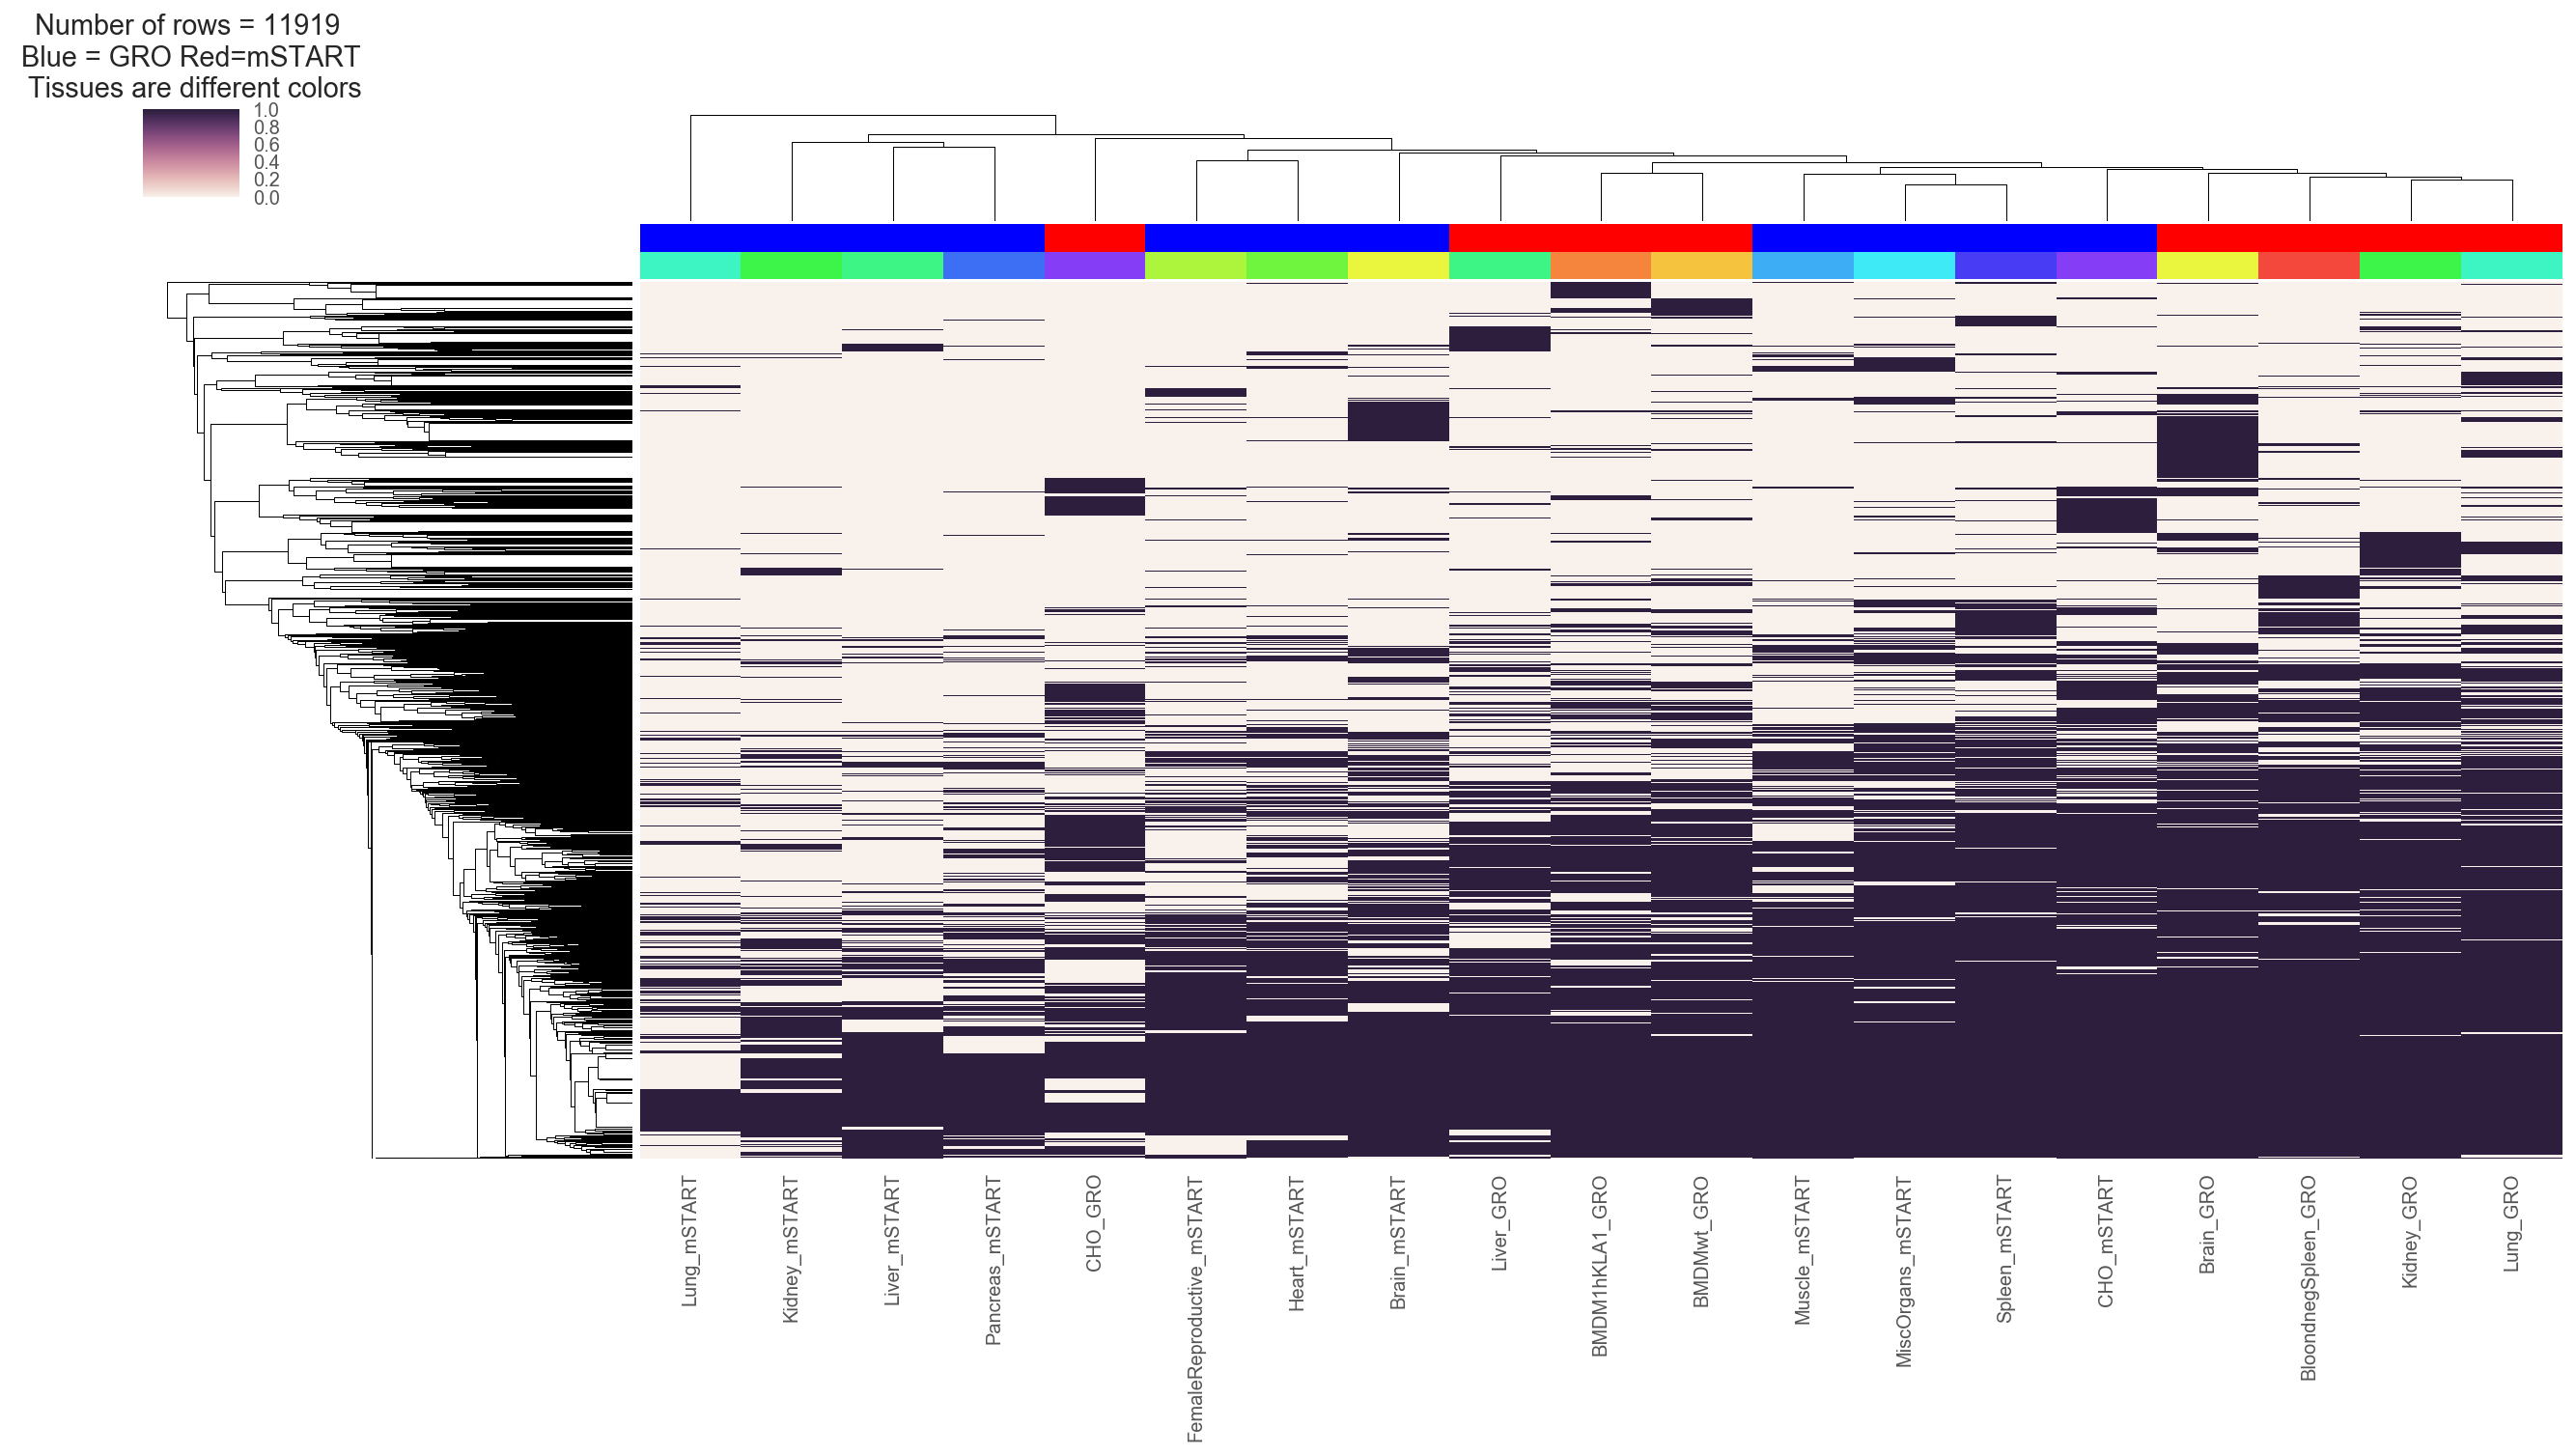

In [13]:
n_tis = len(set(meta_samples['Tissue']))


lut = dict(zip(meta_samples.loc[short_gene_tissue.columns.values,'Experiment'].unique(), "rbg"))
col_colors = meta_samples.loc[short_gene_tissue.columns.values,'Experiment'].map(lut)

lut2 = dict(zip(meta_samples.loc[short_gene_tissue.columns.values,'Tissue'].unique(), sns.hls_palette(n_tis,s=0.9)))
col_colors2 = meta_samples.loc[short_gene_tissue.columns.values,'Tissue'].map(lut2)

g = sns.clustermap((short_gene_tissue>0),col_cluster=True,figsize=(20,10),metric='jaccard',
                   yticklabels=False,col_colors=[col_colors,col_colors2],xticklabels=meta_samples.loc[short_gene_tissue.columns.values,'Short'])

# g = sns.clustermap(short_gene_tissue,col_cluster=True,figsize=(20,10),metric='jaccard',row_cluster=False
#                    ,yticklabels=False)

title = 'Number of rows = %d \n Blue = GRO Red=mSTART \n Tissues are different colors' % len(short_gene_tissue)
plt.title(title)
g.savefig('Results/Figures/binary_promoter_gene_cluster.png',bbox_inches='tight')

% --NotebookApp.iopub_data_rate_limit=10000000000

In [ ]:
curr = short_gene_tissue.loc[:,((short_gene_tissue.columns.str.contains('GRO')) | 
                      (short_gene_tissue.columns.str.contains('(CHO).*(mSTART)')))
                     & (~short_gene_tissue.columns.str.contains('(CHO).*(GRO)')) ]

curr = curr[~((curr == 0).all(axis=1))]

In [43]:
curr.shape

(11361, 8)

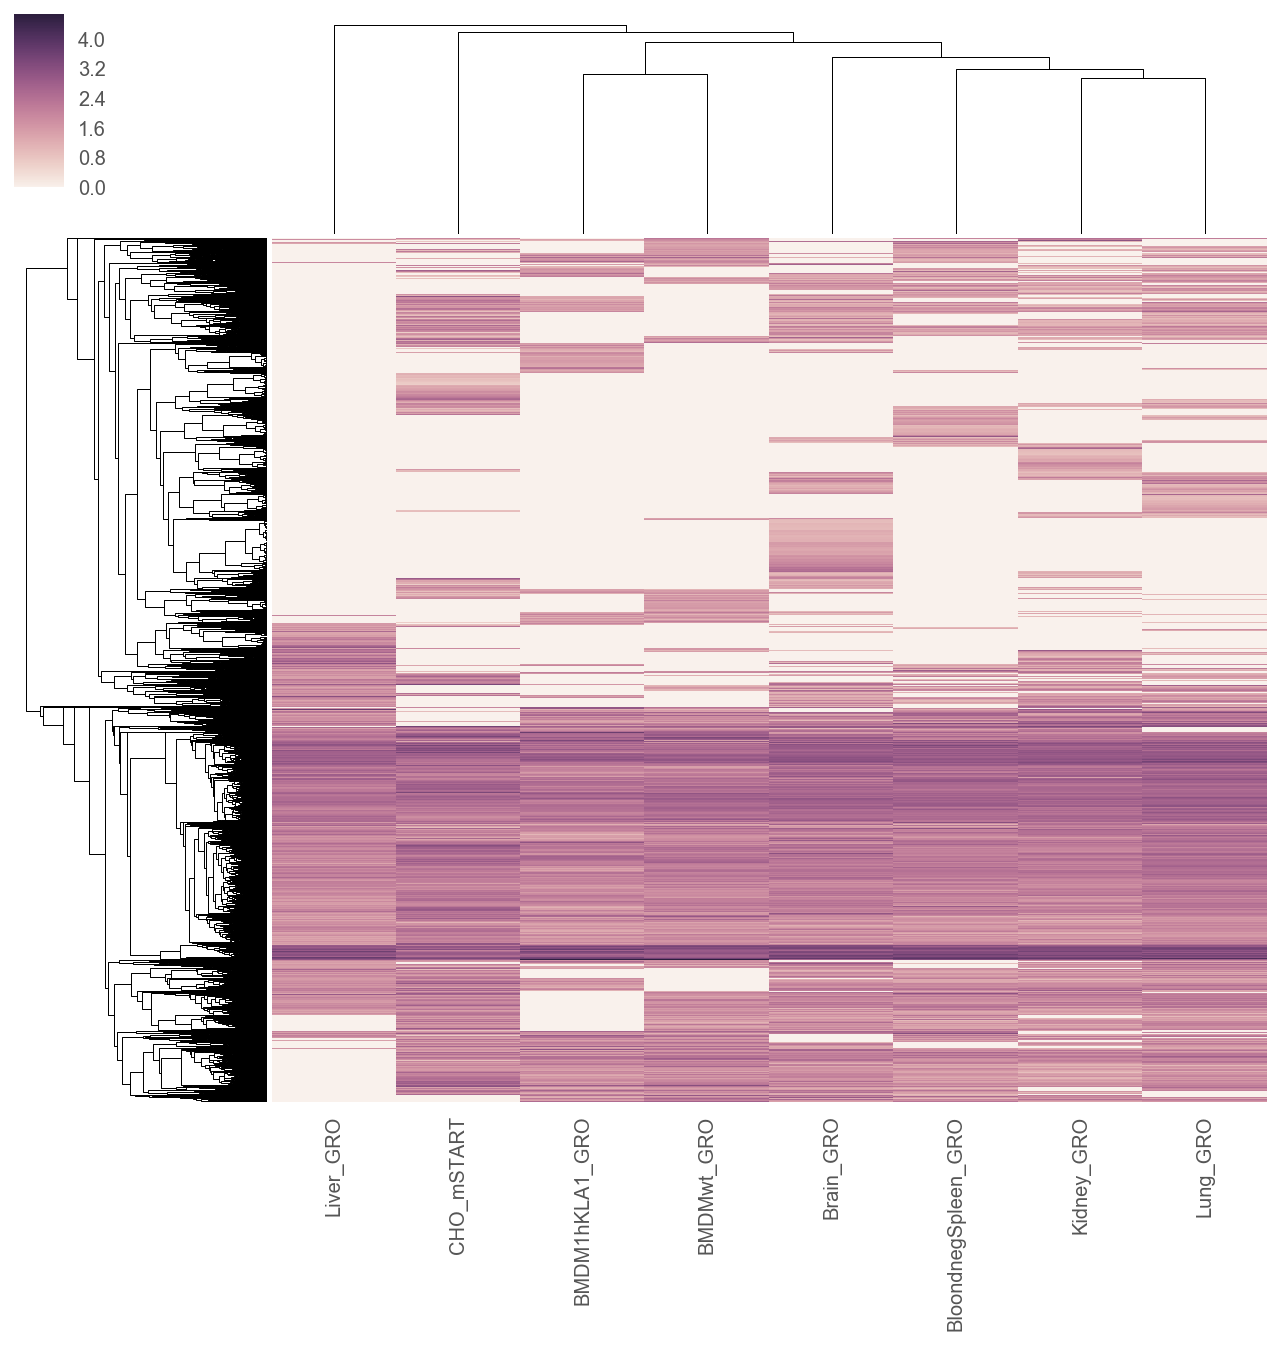

In [58]:
g = sns.clustermap(np.log10(curr+1),col_cluster=True,
                   yticklabels=False,xticklabels=meta_samples.loc[curr.columns.values,'Short'])


In [60]:
(curr>0).astype(bool)

,BloondnegSpleen/GRO/f04_peaks/merge_bg_2.peak,BMDM1hKLA1/GRO/f04_peaks/merge_bg_2.peak,BMDMwt/GRO/f04_peaks/merge_bg_2.peak,Brain/GRO/f04_peaks/merge_bg_2.peak,Kidney/GRO/f04_peaks/merge_bg_2.peak,Liver/GRO/f04_peaks/merge_bg_2.peak,Lung/GRO/f04_peaks/merge_bg_2.peak,CHO/mSTART/f04_peaks/merge_bg_2.peak
SERHL,True,True,True,True,True,True,True,True
RRP7A,False,False,False,True,False,False,False,True
POLDIP3,True,True,True,True,True,True,True,True
CYB5R3,False,True,True,False,False,False,False,True
A4GALT,True,True,True,True,True,False,True,False
ARFGAP3,True,True,True,True,True,True,True,True
PACSIN2,True,True,True,True,True,True,True,True
TTLL1,True,True,True,True,True,True,True,False
BIK,False,False,False,False,False,True,False,True
MCAT,True,False,True,True,True,False,True,True


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


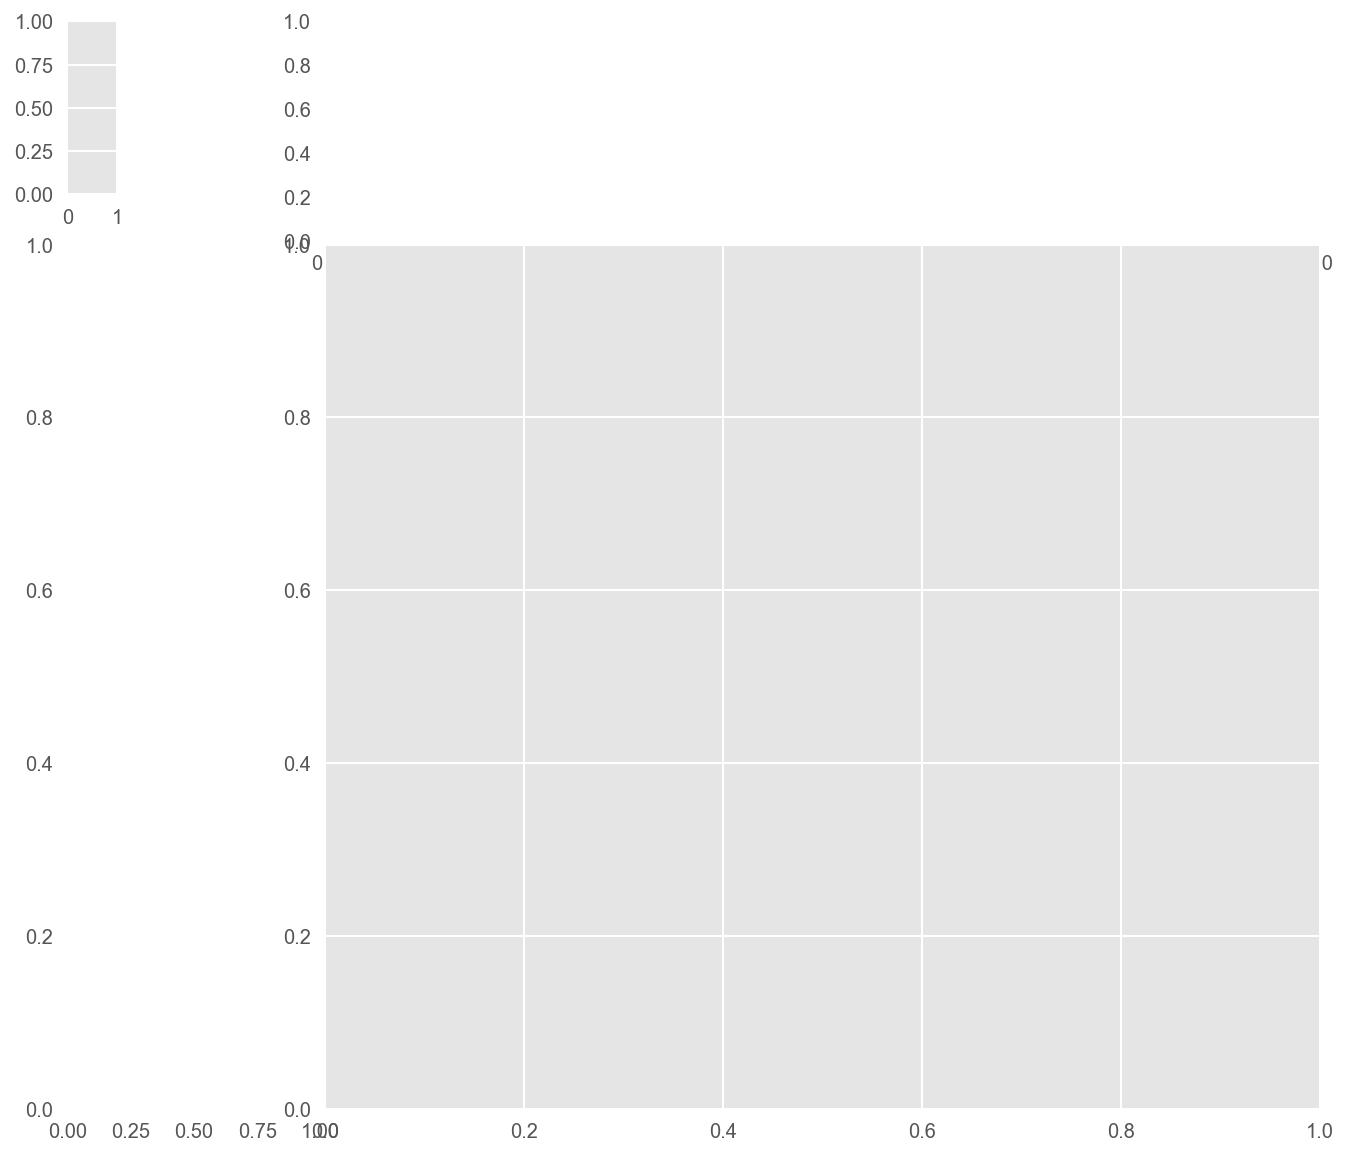

In [62]:
g = sns.clustermap((curr>0).astype(bool),col_cluster=True,metric='jaccard',
                   yticklabels=False,xticklabels=meta_samples.loc[curr.columns.values,'Short'])


/home/isshamie/software/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  
/home/isshamie/software/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


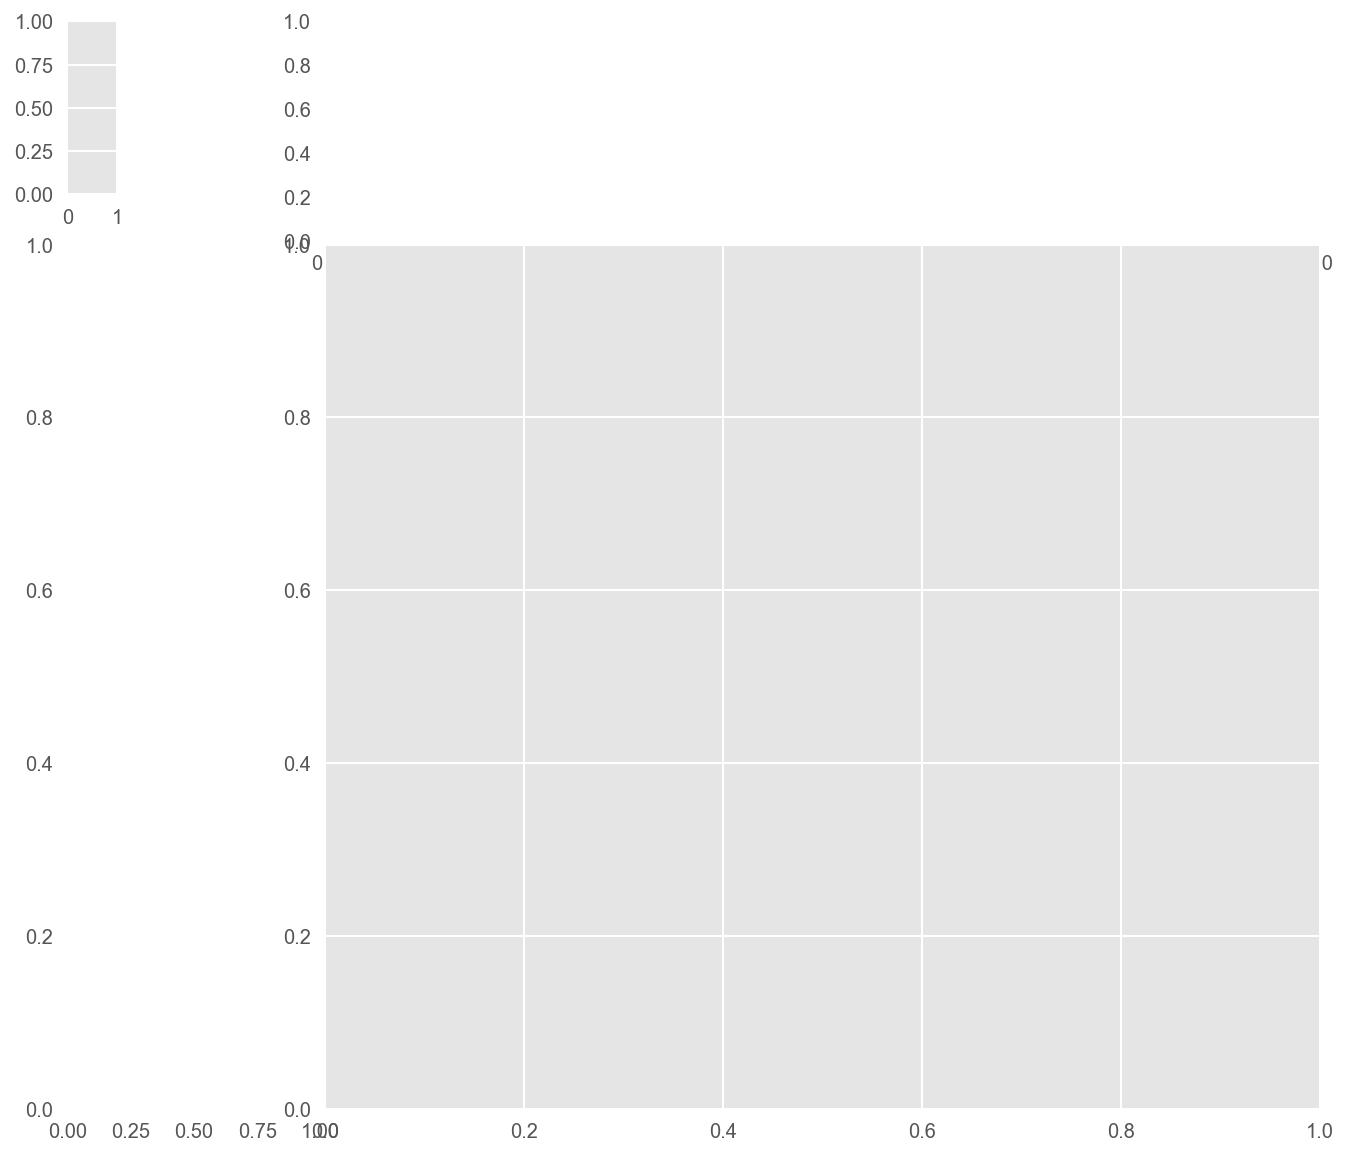

In [41]:
n_tis = len(set(short_gene_tissue.columns.values))


# lut = dict(zip(meta_samples.loc[curr.columns.values,'Experiment'].unique(), "rbg"))
# col_colors = meta_samples.loc[curr.columns.values,'Experiment'].map(lut)

# lut2 = dict(zip(meta_samples.loc[curr.columns.values,'Tissue'].unique(), sns.hls_palette(n_tis,s=0.9)))
# col_colors2 = meta_samples.loc[curr.columns.values,'Tissue'].map(lut2)

g = sns.clustermap((curr>0),col_cluster=True,metric='jaccard',
                   yticklabels=False,xticklabels=meta_samples.loc[curr.columns.values,'Short'])
#col_colors=[col_colors,col_colors2]

title = 'Number of rows = %d \n Blue = GRO Red=mSTART \n Tissues are different colors' % len(curr)
plt.title(title)
g.savefig('Results/Figures/binary_promoter_GRO_gene_cluster.png',bbox_inches='tight')